In [29]:
import pandas as pd
import numpy as np
import random
import re
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
IMAGE_HEIGHT = 100
IMAGE_WIDTH = 100
NUM_CLASSES = 7
BATCH_SIZE = 32
EPOCHS = 80
TEST_BATCH_SIZE = 32

In [3]:
# The training images_path are stored in the training_images_path list
training_images_path = []
# The training labels are stored in the training_labels list
training_labels = []
# The testing images_path are stored in the testing_images_path list
testing_images_path = []
# The testing labels are stored in the testing_labels list
testing_labels = []

path = "./archive"
for directory in os.listdir(path):
    if not directory.startswith('.'):
        images_path = []
        labels =[]
        for img in os.listdir(os.path.join(path,directory)):
            if len(re.findall('.png',img.lower())) != 0 or len(re.findall('.jpg',img.lower())) != 0 or len(re.findall('.jpeg',img.lower())) != 0:
                img_path = os.path.join(os.path.join(path,directory),img)
                images_path.append(img_path)
                labels.append(directory)
        # Split the images_path into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(images_path, labels, test_size=0.1, random_state=42)
        training_images_path.extend(X_train)
        training_labels.extend(y_train)
        testing_images_path.extend(X_test)
        testing_labels.extend(y_test)
        print(f"Directory: {directory}, Training images: {len(X_train)}, Testing images: {len(X_test)}")

Directory: Big Truck, Training images: 519, Testing images: 58
Directory: City Car, Training images: 4191, Testing images: 466
Directory: Multi Purpose Vehicle, Training images: 2384, Testing images: 265
Directory: Sedan, Training images: 2357, Testing images: 262
Directory: Sport Utility Vehicle, Training images: 1643, Testing images: 183
Directory: Truck, Training images: 1035, Testing images: 115
Directory: Van, Training images: 1950, Testing images: 217


In [4]:
# Create training and testing DataFrame to store the images_path and labels
training_df = pd.DataFrame({'images_path': training_images_path, 'labels': training_labels})
testing_df = pd.DataFrame({'images_path': testing_images_path, 'labels': testing_labels})
training_df.shape, testing_df.shape

# shuffle the training DataFrame
training_df = training_df.sample(frac=1).reset_index(drop=True)

In [5]:
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_data_gen = ImageDataGenerator(
    rescale=1./255
)

In [6]:
# Create the training, validation and testing generators
train_generator = train_data_gen.flow_from_dataframe(
    training_df,
    x_col='images_path',
    y_col='labels',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='training'
)

validation_generator = train_data_gen.flow_from_dataframe(
    training_df,
    x_col='images_path',
    y_col='labels',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='validation'
)

test_generator = test_data_gen.flow_from_dataframe(
    testing_df,
    x_col='images_path',
    y_col='labels',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='categorical',
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

Found 11264 validated image filenames belonging to 7 classes.
Found 2815 validated image filenames belonging to 7 classes.
Found 1566 validated image filenames belonging to 7 classes.


In [7]:
# Create the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [8]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [10]:
# Fit the model with the updated generators
predictor = model.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator, callbacks=[callback])

Epoch 1/80


c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


352/352 ━━━━━━━━━━━━━━━━━━━━ 98s 272ms/step - accuracy: 0.3104 - loss: 1.7353 - val_accuracy: 0.4575 - val_loss: 1.3122
Epoch 2/80
352/352 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.4577 - loss: 1.3125 - val_accuracy: 0.5734 - val_loss: 1.0289
Epoch 3/80
352/352 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.5314 - loss: 1.1077 - val_accuracy: 0.6412 - val_loss: 0.9295
Epoch 4/80
352/352 ━━━━━━━━━━━━━━━━━━━━ 28s 78ms/step - accuracy: 0.5892 - loss: 0.9874 - val_accuracy: 0.6803 - val_loss: 0.7960
Epoch 5/80
352/352 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.6346 - loss: 0.8679 - val_accuracy: 0.6927 - val_loss: 0.7647
Epoch 6/80
352/352 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.6717 - loss: 0.7857 - val_accuracy: 0.7385 - val_loss: 0.6525
Epoch 7/80
352/352 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - accuracy: 0.7197 - loss: 0.6974 - val_accuracy: 0.7567 - val_loss: 0.6150
Epoch 8/80
352/352 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - accuracy: 0.7412 - loss: 0.6202 - val_accura

In [11]:
# Print out the testing accuracy and loss
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - accuracy: 0.8661 - loss: 0.6530
Test loss: 0.7304099798202515
Test accuracy: 0.8678160905838013


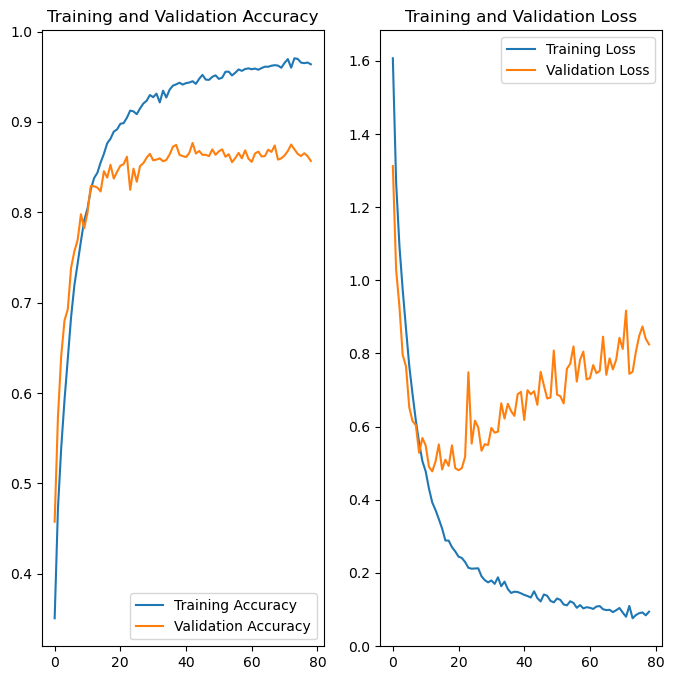

In [12]:
# Plot the training and validation accuracy and loss
accuracy = predictor.history['accuracy']
val_accuracy = predictor.history['val_accuracy']

loss = predictor.history['loss']
val_loss = predictor.history['val_loss']

epochs_range = range(len(accuracy))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
label_names = list(train_generator.class_indices.keys())
print("All class labels:", label_names)

All class labels: ['Big Truck', 'City Car', 'Multi Purpose Vehicle', 'Sedan', 'Sport Utility Vehicle', 'Truck', 'Van']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Actual Vehicle Type: Truck
Predicted Vehicle Type: Truck


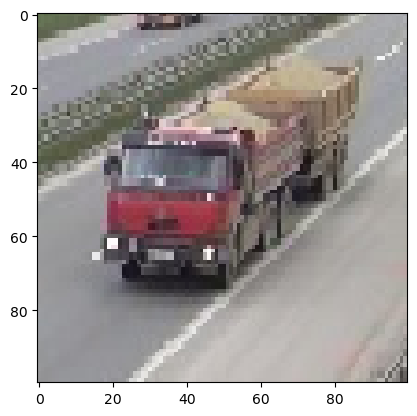

In [14]:
# Predict the vehicle type of a random image
img_num = random.randrange(0, 31)
gen_num = random.randrange(0, 47)

sample_img, sample_label = test_generator[gen_num]
prediction = model.predict(sample_img)
print("Actual Vehicle Type:", label_names[np.argmax(sample_label[img_num])])
print("Predicted Vehicle Type:", label_names[np.argmax(prediction[img_num])])

plt.imshow(sample_img[img_num])
plt.show()

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


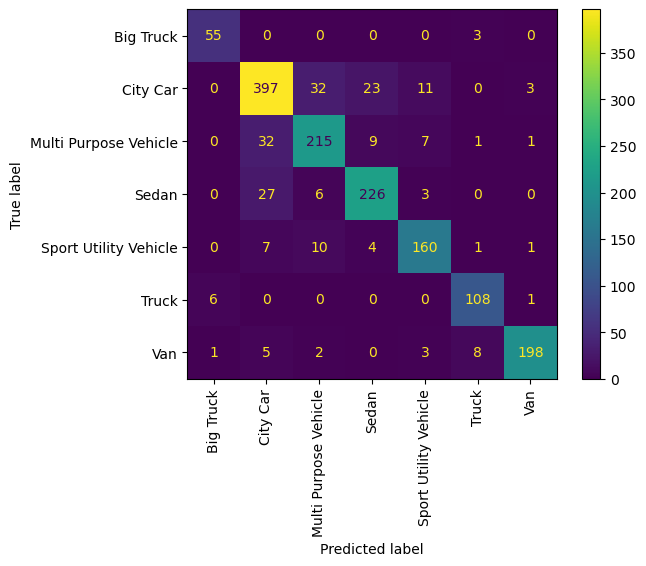

In [23]:
# Build and Display the confusion matrix
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(xticks_rotation='vertical')
plt.show()

In [25]:
# Generate the classficication report
print(classification_report(y_true, y_pred, target_names=label_names))

                       precision    recall  f1-score   support

            Big Truck       0.89      0.95      0.92        58
             City Car       0.85      0.85      0.85       466
Multi Purpose Vehicle       0.81      0.81      0.81       265
                Sedan       0.86      0.86      0.86       262
Sport Utility Vehicle       0.87      0.87      0.87       183
                Truck       0.89      0.94      0.92       115
                  Van       0.97      0.91      0.94       217

             accuracy                           0.87      1566
            macro avg       0.88      0.89      0.88      1566
         weighted avg       0.87      0.87      0.87      1566



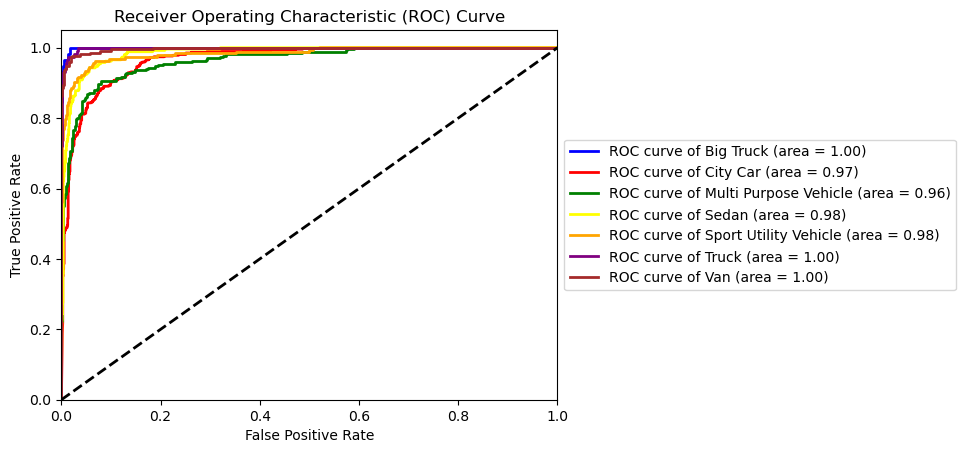

In [40]:
# Plot the ROC curve using OvR strategy
y_test = label_binarize(y_true, classes=[0, 1, 2, 3, 4, 5, 6])
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'brown']
for i, class_name, color in zip(range(NUM_CLASSES), label_names, colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of {class_name} (area = {roc_auc[i]:0.2f})')

# put the legend outside the plot
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()